In [1]:
import torch
import torch.nn as nn
torch.set_default_dtype(torch.float64)
from collections import OrderedDict
import math
import numpy as np
import sympy as sp
import seaborn as sns
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.stats import qmc
import scipy.io

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class ChebyKANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, degree):
        super(ChebyKANLayer, self).__init__()
        self.inputdim = input_dim
        self.outdim = output_dim
        self.degree = degree

        self.cheby_coeffs = nn.Parameter(torch.empty(input_dim, output_dim, degree + 1))
        nn.init.xavier_normal_(self.cheby_coeffs)
        self.register_buffer("arange", torch.arange(0, degree + 1, 1))    

    def forward(self, x):
        x = torch.reshape(x, (-1, self.inputdim))
        x = torch.tanh(x)

        cheby = torch.ones(x.shape[0], self.inputdim, self.degree + 1, 
                          device=x.device) #degree若为4，则cheby有5列
        
        if self.degree > 0:
            cheby[:, :, 1] = x
        
        for i in range(2, self.degree + 1):
            cheby[:, :, i] = 2 * x * cheby[:, :, i - 1].clone() - cheby[:, :, i - 2].clone() #T_0(x) = 1；T_1(x) = x；T_{n+1}(x) = 2xT_n(x) - T_{n-1}(x) 对于 n ≥ 1

        y = torch.einsum('bid,iod->bo', cheby, self.cheby_coeffs)  
        y = y.view(-1, self.outdim)
        return y

# 修改DNNLayer，不再需要hidden_dim参数
class DNNLayer(nn.Module):
    def __init__(self, input_dim, output_dim, activation=nn.Tanh):
        super(DNNLayer, self).__init__()
        # 直接使用输入维度作为内部隐藏层维度（从layer_sizes推导）
        self.layer = nn.Sequential(
            nn.Linear(input_dim, input_dim),  # 隐藏层维度 = 输入维度
            activation(),
            nn.Linear(input_dim, output_dim)
        )
        
    def forward(self, x):
        return self.layer(x)

# 混合模型：仅使用layer_sizes定义所有维度
class HybridKAN_DNN(nn.Module):
    def __init__(self, layer_sizes, cheby_degree, lb, ub):
        super(HybridKAN_DNN, self).__init__()
        self.lb = lb
        self.ub = ub
        self.layers = nn.ModuleList()
        
        # 完全通过layer_sizes定义各层维度
        for i in range(len(layer_sizes) - 1):
            if i % 2 != 0:  # 偶数索引：ChebyKAN层
                self.layers.append(ChebyKANLayer(
                    input_dim=layer_sizes[i],
                    output_dim=layer_sizes[i+1],
                    degree=cheby_degree
                ))
            else:  # 奇数索引：DNN层（内部维度自动从layer_sizes[i]获取）
                self.layers.append(DNNLayer(
                    input_dim=layer_sizes[i],
                    output_dim=layer_sizes[i+1]
                ))
    
    def forward(self, x):
        out = 2 * (x - self.lb) / (self.ub - self.lb) - 1
        for layer in self.layers:
            out = layer(out)
        return out

In [4]:
# the physics-guided neural network
class PIKDN(nn.Module):
    def __init__(self, X_ub,X_lb,X_ic,X_res,u_ic,alpha,beta,gamma,layers, degree, lb, ub):
        super(PIKDN, self).__init__()
        # boundary conditions
        
        self.z_ub = torch.tensor(X_ub[:, 0:1], requires_grad=True).double().to(device)
        self.t_ub = torch.tensor(X_ub[:, 1:2], requires_grad=True).double().to(device)

        self.z_lb = torch.tensor(X_lb[:, 0:1], requires_grad=True).double().to(device)
        self.t_lb = torch.tensor(X_lb[:, 1:2], requires_grad=True).double().to(device)

        self.z_ic = torch.tensor(X_ic[:, 0:1], requires_grad=True).double().to(device)
        self.t_ic = torch.tensor(X_ic[:, 1:2], requires_grad=True).double().to(device)
        self.u_ic = torch.tensor(u_ic).double().to(device)
        #self.v_ic = torch.tensor(v_ic).double().to(device)

        self.z_res = torch.tensor(X_res[:, 0:1], requires_grad=True).double().to(device)
        self.t_res = torch.tensor(X_res[:, 1:2], requires_grad=True).double().to(device)

        self.alpha = torch.tensor(alpha).double().to(device)
        self.beta = torch.tensor(beta).double().to(device)
        self.gamma = torch.tensor(gamma).double().to(device)

        self.lb = torch.tensor(lb).double().to(device)  # 归一化下界
        self.ub = torch.tensor(ub).double().to(device)  # 归一

        self.layers = layers
        
        self.net = HybridKAN_DNN(layers, degree, self.lb, self.ub).to(device)

        self.iter = 1

        self.optimizer1 = torch.optim.Adam(self.net.parameters(),lr=1e-3)

        self.optimizer2 = torch.optim.LBFGS(
            self.net.parameters(), 
            lr=1.0, #步长缩放因子，用于控制拟牛顿算法中搜索的步长
            max_iter=50000, #最大迭代次数
            max_eval=50000, #函数和梯度最大评估次数
            history_size=50, #存储和更新历史信息的缓存大小
            tolerance_grad=1e-7, #表示梯度的容差，即梯度的变化小于该容差时，算法将终止
            tolerance_change=1.0 * np.finfo(float).eps, #表示优化变化的容差，即参数变化量的绝对值小于该容差时，算法将终止
            line_search_fn="strong_wolfe" #can be "strong_wolfe"
        )

        self.loss_history = {
            'total': [],
            'residual': [],
            'ic': [],
            'b': []
        }
        
    def net_h(self, z, t):  
        H = self.net(torch.cat([z, t], dim=1))
        u = H[:, 0:1]
        v = H[:, 1:2]
        return u,v
        
    def gradient(self, y, x):
        return torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), retain_graph=True, create_graph=True)[0]
    
    def net_b(self, z, t):

        u,v = self.net_h(z, t)
        u_z = self.gradient(u, z)
        v_z = self.gradient(v, z)

        return u, v, u_z, v_z            
    
    def net_ic(self, z, t):

        u, v = self.net_h(z, t)

        return u, v      
    
    def net_f(self, z, t):

        u,v = self.net_h(z, t)
        v_t = self.gradient(v, t)
        v_z = self.gradient(v, z)

        u_t = self.gradient(u, t)
        u_z = self.gradient(u, z)
        u_zz = self.gradient(u_z, z)
        u_zzz = self.gradient(u_zz, z)

        f1 = u_t - v_z
        f2 = v_t + self.alpha * u_z + self.beta * (2*u*u_z) + self.gamma * u_zzz

        return f1, f2

    def loss_func(self):

        self.optimizer1.zero_grad()
        self.optimizer2.zero_grad()

        u_ic_pred, v_ic_pred = self.net_ic(self.z_ic, self.t_ic)

        u_ub_pred, v_ub_pred, u_z_ub_pred, v_z_ub_pred = self.net_b(self.z_ub, self.t_ub)

        u_lb_pred, v_lb_pred, u_z_lb_pred, v_z_lb_pred = self.net_b(self.z_lb, self.t_lb)

        f1_res_pred, f2_res_pred = self.net_f(self.z_res, self.t_res)

        u_ic_pred_t=self.gradient(u_ic_pred,self.t_ic)

        loss_res1 = torch.mean(f1_res_pred**2)
        loss_res2 = torch.mean(f2_res_pred**2)
        loss_res = loss_res1 + loss_res2
        loss_ic1 = torch.mean((u_ic_pred - self.u_ic)**2)
        #loss_ic2 = torch.mean((v_ic_pred - self.v_ic)**2)
        loss_ic2=torch.mean((u_ic_pred_t-0.01)**2)
        loss_b1 = torch.mean((u_ub_pred - u_lb_pred)**2)
        loss_b2 = torch.mean((v_ub_pred - v_lb_pred)**2)
        loss_b3 = torch.mean((u_z_ub_pred - u_z_lb_pred)**2)
        loss_b4 = torch.mean((v_z_ub_pred - v_z_lb_pred)**2)

        loss_ic = loss_ic1 + loss_ic2
        loss_b = loss_b1 + loss_b2 + loss_b3 + loss_b4

        loss = loss_res + loss_ic1 + loss_ic2 + loss_b1 + loss_b2 + loss_b3 + loss_b4

        # self.loss_history['total'].append(loss.item())
        # self.loss_history['residual'].append(loss_res.item())
        # self.loss_history['ic'].append(loss_ic.item())
        # self.loss_history['b'].append(loss_b.item())
        
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            self.loss_history['total'].append(loss.item())
            self.loss_history['residual'].append(loss_res.item())
            self.loss_history['ic'].append(loss_ic.item())
            self.loss_history['b'].append(loss_b.item())
            print(
                'Iter %d, Loss: %.5e, Loss_res: %.5e, Loss_ic1: %.5e, Loss_ic2: %.5e, Loss_b1: %.5e, Loss_b2: %.5e, Loss_b3: %.5e, Loss_b4: %.5e' % 
                (   self.iter, 
                    loss.item(), 
                    loss_res.item(), 
                    loss_ic1.item(),
                    loss_ic2.item(), 
                    loss_b1.item(),
                    loss_b2.item(),
                    loss_b3.item(),
                    loss_b4.item()
                )
            )

        return loss
    
    def train(self):
        self.net.train()
        print("采用Adam优化器")
        for i in range(20000):
            self.optimizer1.step(self.loss_func)
        # 然后运行lbfgs优化器
        print("采用L-BFGS优化器")
        self.optimizer2.step(self.loss_func) 
            
    def predict(self, X):
        
        z = torch.tensor(X[:, 0:1], requires_grad=True).double().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).double().to(device)

        self.net.eval()
        u,v = self.net_h(z, t)
        u = u.detach().cpu().numpy()
        v = v.detach().cpu().numpy()

        return u, v

In [5]:
alpha = -1
beta = -3
gamma = -1

N_res = 2000
N_b = 100
N_ic = 100

x = np.linspace(-15, 15, 201)
t = np.linspace(0, 1, 201) 
x_mesh, t_mesh = np.meshgrid(x, t)

X = np.hstack((x_mesh.flatten()[:,None], t_mesh.flatten()[:,None]))

lb = X.min(0) #下界x'QxQ
ub = X.max(0)  #上界 

def lhs(n, size):
    """生成n维拉丁超立方采样，返回size个样本点"""
    sampler = qmc.LatinHypercube(d=n)
    return sampler.random(n=size)

# 使用简洁形式进行采样（与你要求的形式一致）
#X_res = lb + (ub - lb) * lhs(2, N_res)  # 2维残差点采样
X_res = np.load('/kaggle/input/x-res-points/X_res_points..npy',allow_pickle=True)

t_samples = lb[1] + (ub[1] - lb[1]) * lhs(1, N_b)  # 时间t的采样：[N_b, 1]

# 上边界点（x=ub[0]，与下边界对称）
X_ub = np.hstack((ub[0] * np.ones((N_b, 1)),t_samples))
X_lb = np.hstack((lb[0] * np.ones((N_b, 1)),t_samples))

X_ic = np.hstack((lb[0] + (ub[0] - lb[0]) * lhs(1, N_ic), 
                  lb[1] * np.ones((N_ic, 1))))  # 初始条件点

In [6]:
u_ic=np.exp(-1*(X_ic[:,0:1])**2)  #YS修改，第一个初始条件，将解析解注释掉

In [7]:
degree = 3
layers = [2] + 4 * [24] + [2]

model = PIKDN(X_ub, X_lb, X_ic, X_res, u_ic, alpha, beta, gamma, layers, degree, lb, ub)

In [8]:
model

PIKDN(
  (net): HybridKAN_DNN(
    (layers): ModuleList(
      (0): DNNLayer(
        (layer): Sequential(
          (0): Linear(in_features=2, out_features=2, bias=True)
          (1): Tanh()
          (2): Linear(in_features=2, out_features=24, bias=True)
        )
      )
      (1): ChebyKANLayer()
      (2): DNNLayer(
        (layer): Sequential(
          (0): Linear(in_features=24, out_features=24, bias=True)
          (1): Tanh()
          (2): Linear(in_features=24, out_features=24, bias=True)
        )
      )
      (3): ChebyKANLayer()
      (4): DNNLayer(
        (layer): Sequential(
          (0): Linear(in_features=24, out_features=24, bias=True)
          (1): Tanh()
          (2): Linear(in_features=24, out_features=2, bias=True)
        )
      )
    )
  )
)

In [9]:
model.train()

采用Adam优化器
Iter 100, Loss: 3.88029e-02, Loss_res: 1.11963e-04, Loss_ic1: 3.85753e-02, Loss_ic2: 1.10372e-04, Loss_b1: 3.35248e-06, Loss_b2: 5.60980e-07, Loss_b3: 1.25877e-06, Loss_b4: 8.71010e-08
Iter 200, Loss: 2.69549e-02, Loss_res: 1.22278e-03, Loss_ic1: 2.55878e-02, Loss_ic2: 2.34929e-05, Loss_b1: 6.97076e-05, Loss_b2: 1.09548e-05, Loss_b3: 3.87584e-05, Loss_b4: 1.46797e-06
Iter 300, Loss: 6.96482e-03, Loss_res: 2.99410e-03, Loss_ic1: 3.62056e-03, Loss_ic2: 2.68725e-04, Loss_b1: 3.77139e-05, Loss_b2: 3.42045e-05, Loss_b3: 5.96293e-07, Loss_b4: 8.91879e-06
Iter 400, Loss: 3.15256e-03, Loss_res: 1.77089e-03, Loss_ic1: 1.22348e-03, Loss_ic2: 1.49635e-04, Loss_b1: 6.46485e-07, Loss_b2: 4.59602e-06, Loss_b3: 2.13786e-06, Loss_b4: 1.17370e-06
Iter 500, Loss: 1.98827e-03, Loss_res: 1.22316e-03, Loss_ic1: 6.84379e-04, Loss_ic2: 7.03369e-05, Loss_b1: 2.65138e-07, Loss_b2: 6.07386e-06, Loss_b3: 3.63151e-06, Loss_b4: 4.19281e-07
Iter 600, Loss: 1.34506e-03, Loss_res: 8.33735e-04, Loss_ic1: 4.4

In [10]:
u_p,v_p = model.predict(X)

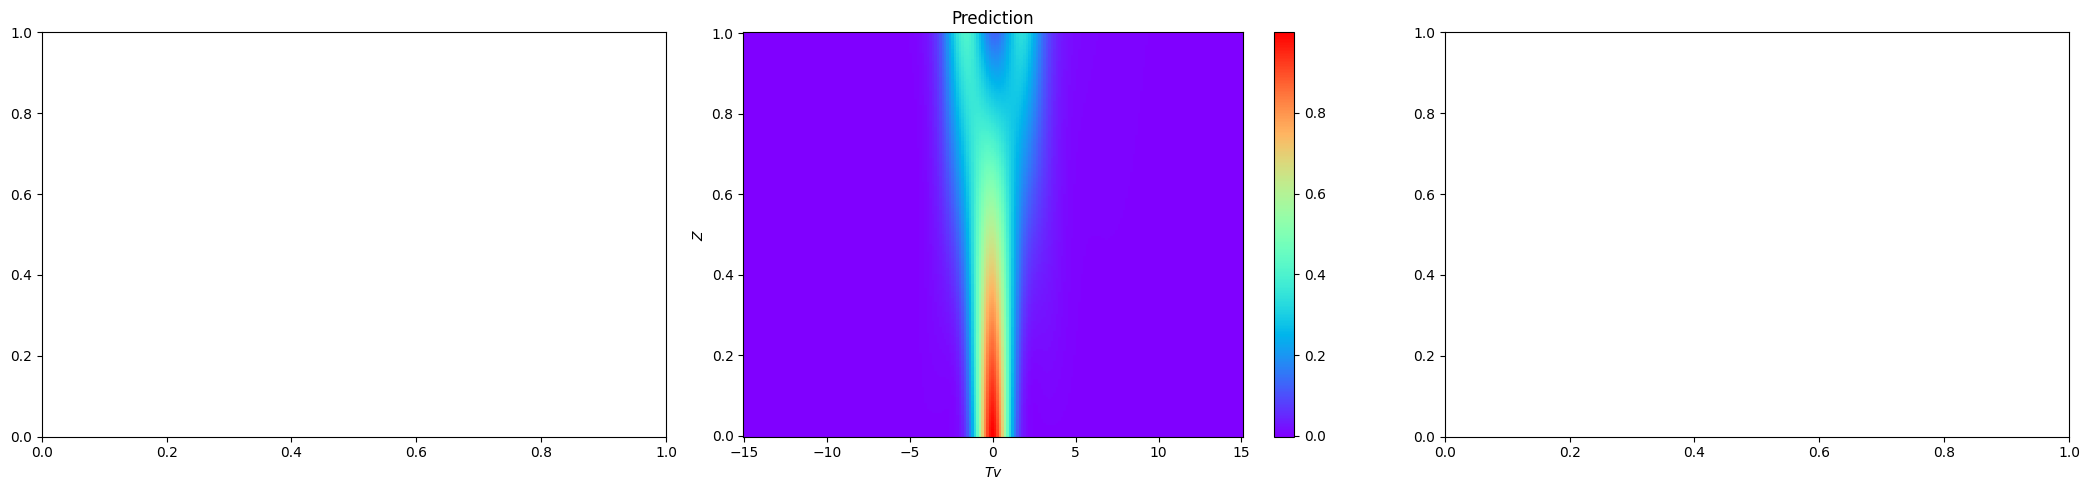

In [11]:
H_pred = griddata(X, u_p.flatten(), (x_mesh,t_mesh), method='cubic')

def plot_all(T, X, H_pred):
    fig, axes = plt.subplots(1, 3, figsize=(21, 5))  # 创建1行3列的子图布局
    
    # 预测值图
    im1 = axes[1].pcolor(T, X, H_pred, cmap='rainbow')
    axes[1].set_xlabel('$Tv$')
    axes[1].set_ylabel('$Z$')
    axes[1].set_title('Prediction')
    plt.colorbar(im1, ax=axes[1])
    
    plt.tight_layout()
    plt.show()

# 调用函数绘制并排的三幅图
plot_all(x_mesh, t_mesh, H_pred)

/tmp/ipykernel_19/3066993988.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('rainbow')  #


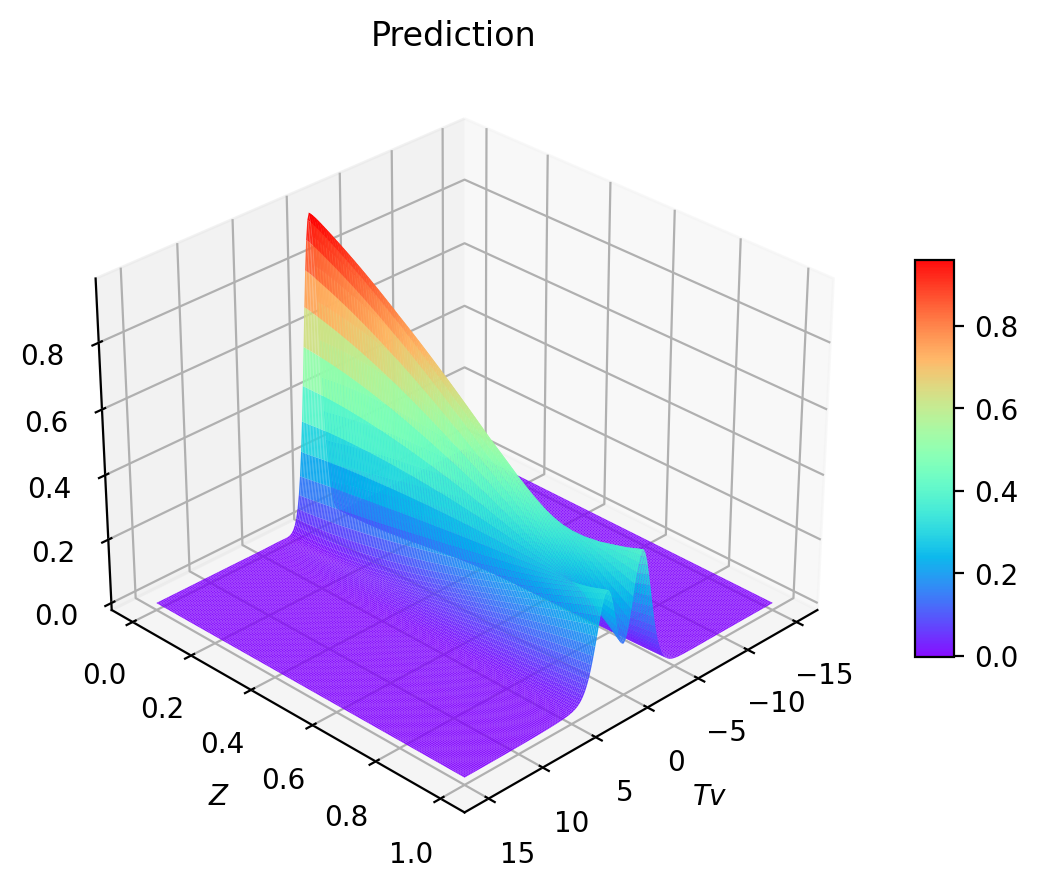

In [12]:
def plot_all_3d(T, X, H_pred, smooth_factor=1.0, dpi=150):
    """
    绘制对比3D图像（真实值、预测值和差值），并优化显示效果
    
    参数:
    - smooth_factor: 控制插值平滑程度的因子
    - dpi: 图像分辨率
    """
    # 创建更高分辨率的图形
    fig = plt.figure(figsize=(21, 5), dpi=dpi)
    
    # 定义共享的颜色映射和视角
    cmap = cm.get_cmap('rainbow')  # 
    #cmap = cm.get_cmap('viridis')  # 使用更现代的颜色映射
    elev, azim = 30, 45  # 定义共享的视角
    
    # 创建更平滑的网格数据（可选）
    if smooth_factor > 1:
        from scipy.ndimage import gaussian_filter
       
        H_pred_smooth = gaussian_filter(H_pred, sigma=smooth_factor)
    else:
        
        H_pred_smooth = H_pred
    

    
    # 定义绘图函数，减少代码重复
    def plot_surface(ax, X, Y, Z, title, cmap=cmap):
        surf = ax.plot_surface(X, Y, Z, cmap=cmap, 
                              linewidth=0, antialiased=True,
                              rstride=1, cstride=1,
                              alpha=0.95)
        ax.set_xlabel('$Tv$')
        ax.set_ylabel('$Z$')
        ax.set_zlabel('h')
        ax.set_title(title)
        ax.view_init(elev=elev, azim=azim)
        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, pad=0.05)
        # 添加网格线增强深度感
        ax.grid(True, linestyle='-', alpha=0.3)
        return surf
    
    # 预测值3D图
    ax1 = fig.add_subplot(132, projection='3d')
    plot_surface(ax1, T, X, H_pred_smooth, 'Prediction')
    
    # 调整布局，确保有足够的空间显示标签和颜色条
    plt.tight_layout(pad=3.0)
    plt.show()

# 示例调用
plot_all_3d(x_mesh, t_mesh, H_pred, smooth_factor=1.2, dpi=200)

In [13]:
data = {
    'x': x_mesh.flatten()[:, None],       # x网格数据（竖排）
    't': t_mesh.flatten()[:, None],       # t网格数据（竖排）
    'h_pred': u_p.flatten()[:, None],     # u预测值（竖排）
    'g_pred': v_p.flatten()[:, None]      # v预测值（竖排）
}

# 保存到单个MAT文件
scipy.io.savemat('PIKDNall_data.mat', data)

In [14]:
# scipy.io.savemat('3wavedata_PIKAN/x.mat', {'array': x_mesh.flatten()[:, None]})
# scipy.io.savemat('3wavedata_PIKAN/t.mat', {'array': t_mesh.flatten()[:, None]})
# scipy.io.savemat('3wavedata_PIKAN/h_true.mat', {'array': u_true.flatten()[:, None]})
# scipy.io.savemat('3wavedata_PIKAN/g_true.mat', {'array': v_true.flatten()[:, None]})
# scipy.io.savemat('3wavedata_PIKAN/h_pred.mat', {'array': u_p.flatten()[:, None]})
# scipy.io.savemat('3wavedata_PIKAN/g_pred.mat', {'array': v_p.flatten()[:, None]})

In [15]:
loss_total = model.loss_history['total']
loss_residual = model.loss_history['residual']
loss_ic = model.loss_history['ic']
loss_b = model.loss_history['b']

In [16]:
num_iterations = len(loss_total)  # 损失记录的总数量（即总迭代次数）
iter_steps = list(range(100, 100 + num_iterations * 100, 100))

In [17]:
# 3. 将数据转换为竖排（列向量）：通过reshape(-1, 1)实现，形状变为(n, 1)
iter_steps_col = np.array(iter_steps).reshape(-1, 1)       # 竖排迭代步数
loss_total_col = np.array(loss_total).reshape(-1, 1)       # 竖排总损失
loss_residual_col = np.array(loss_residual).reshape(-1, 1) # 竖排残差损失
loss_ic_col = np.array(loss_ic).reshape(-1, 1)             # 竖排初始条件损失
loss_b_col = np.array(loss_b).reshape(-1, 1)               # 竖排边界条件损失

# 4. 整理并保存为mat文件（此时所有数据均为列向量）
data_loss = {
    'iter_steps': iter_steps_col,
    'loss_total': loss_total_col,
    'loss_residual': loss_residual_col,
    'loss_ic': loss_ic_col,
    'loss_b': loss_b_col
}

scipy.io.savemat('PIKDNloss_history.mat', data_loss)
print("竖排格式的损失函数和迭代步数已保存为 loss_history.mat")

竖排格式的损失函数和迭代步数已保存为 loss_history.mat
